In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import copy

data = load_boston()
y_indices = data.target
y = np.matrix(data.target).T
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

print(X.shape)

print(y.shape)

(506, 13)
(506, 1)


In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
m_test = M - m_train
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
# y_test_indices = y_indices[test_idx]
print('=======X train =======')
print(X_train.shape,y_train.shape)
print('=======X test =======')
print(X_test.shape,y_test.shape)
# print(y_train)

=======X train =======
(303, 13) (303, 1)
=======X test =======
(203, 13) (203, 1)


In [3]:
# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h3 = 2
h2 = 5
h1 = 10

W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,h3]),
         np.random.normal(0,0.1,[h3,1])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[h3,1]),
         np.random.normal(0,0.1,[1,1])]
L = len(W)-1


In [4]:
def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def tanh_act(z):
    return np.tanh(z)

def tanh_actder(z):
    az = act(z)
    prod = np.multiply(az,az)
    return (1 - prod)

def relu_act(z):
    return np.maximum(0,z)

def relu_actder(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

def linear_act(z):
    return z
    
def linear_actder(z):
    return 1


In [7]:
def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = relu_act(z)
        else:
            a = relu_act(z)
    return a

####MSE
# def loss_multi(y, yhat):
#     return - np.dot(y, np.log(yhat))

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

def loss_mse(y,yhat):
    return np.sum(np.power((y-yhat),2),axis=0)/ y.shape[0]

In [11]:
# Train for 100 epochs with mini-batch size 1

cost_arr = [] 
cost_arr_test = []
best_this_loss = 1e-16
alpha = 0.001
max_iter = 100
iter_stop = 0

for iter in range(0, max_iter):
    loss_this_iter = 0
    loss_this_iter_test = 0
    order = np.random.permutation(m_train)
    order_test = np.random.permutation(m_test)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(relu_act(z[l]))
            else:
                a.append(relu_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss_mse(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                # depends on your activation function in th at particular layer 
                # in this case all our activation functions are sigmoid 
                delta[l-1] = np.multiply(relu_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):            
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
        
    for j in range(0, m_test):

        # Grab the pattern order[j]

        x_this_test = X_test[order_test[j],:].T
        y_this_test = y_test[order_test[j],:]

        # Feed forward step
        a_test = [x_this_test]
        z_test = [[]]
        for l in range(1,L+1):
            z_test.append(W[l].T*a_test[l-1]+b[l])
            if (l == L):
                a_test.append(relu_act(z_test[l]))
            else:
                a_test.append(relu_act(z_test[l]))
        
        loss_this_pattern_test = loss_mse(y_this_test,a_test[L])
        loss_this_iter_test = loss_this_iter_test + loss_this_pattern_test
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.


    cost_arr.append(loss_this_iter[0,0])
    cost_arr_test.append(loss_this_iter_test[0,0])
    
    if loss_this_iter_test < best_this_loss:
        w_best = copy.deepcopy(W) #w
        b_best = copy.deepcopy(b) #b
        iter_best = iter
        print('Early stopping at Epoch %d' % (iter))
        break
    
#     tol = 0.0001
#     if len(cost_arr_test) > 50:
#         if cost_arr_test[-2] - cost_arr_test[-1] < tol:
#             iter_stop = iter
#             print('Epoch %d train loss %f' % (iter, loss_this_iter))
#             print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
#             print('Iter stop: ', iter_stop)
#             break

    print('Epoch %d train loss %f' % (iter, loss_this_iter))
    print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
    iter_stop = iter


Epoch 0 train loss 23543.733412
Epoch 0 test loss 19274.238910
Epoch 1 train loss 23543.171258
Epoch 1 test loss 19270.481767
Epoch 2 train loss 23542.825511
Epoch 2 test loss 19267.232619
Epoch 3 train loss 23542.147774
Epoch 3 test loss 19267.034204
Epoch 4 train loss 23541.417855
Epoch 4 test loss 19259.831252
Epoch 5 train loss 23541.654873
Epoch 5 test loss 19263.212378
Epoch 6 train loss 23541.771341
Epoch 6 test loss 19264.334465
Epoch 7 train loss 23542.689682
Epoch 7 test loss 19262.094367
Epoch 8 train loss 23542.390961
Epoch 8 test loss 19260.197709
Epoch 9 train loss 23542.303953
Epoch 9 test loss 19257.557239
Epoch 10 train loss 23540.933628
Epoch 10 test loss 19252.712389
Epoch 11 train loss 23542.368848
Epoch 11 test loss 19255.064508
Epoch 12 train loss 23541.081253
Epoch 12 test loss 19259.690200
Epoch 13 train loss 23541.843875
Epoch 13 test loss 19255.951722
Epoch 14 train loss 23541.382074
Epoch 14 test loss 19253.687554
Epoch 15 train loss 23541.689551
Epoch 15 tes

In [12]:
# Get test set accuracy

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i,:].T, W, b))
    return y_pred

y_test_predicted = predict_y(W, b, X_test)

# y_correct = y_test_predicted == y_test
# test_accuracy = np.sum(y_correct) / len(y_correct)
# print('Test accuracy: %.4f' % (test_accuracy))

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_test_predicted)
r2_score = r2_score(y_test, y_test_predicted)
print(mse)
print(r2_score)

624.7123645320196
-5.635452740741806


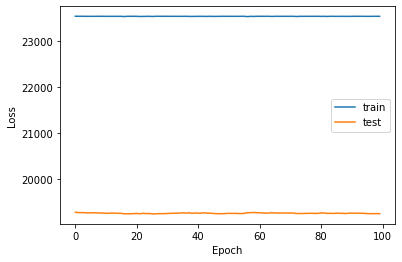

In [13]:
plt.plot(np.arange(0,iter_stop+1,1), cost_arr[0:], label = "train")
plt.plot(np.arange(0,iter_stop+1,1), cost_arr_test, label = "test")

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()